In [1]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
import tensorflow as tf

import seaborn as sns
%matplotlib inline 

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

import utils

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2991289856021824869
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10966958080
locality {
  bus_id: 1
}
incarnation: 9771279223605662646
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')
print(AUDIO_DIR)

/home/sayan/workspace/Song-Popularity/data/fma_small


In [4]:
tracks = utils.load('../data/tracks.csv')
features = utils.load('../data/features.csv')
echonest = utils.load('../data/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

In [5]:
# combo_df = pd.read_csv("../data/combined_features.csv") 
mod_tracks = pd.read_csv("../data/mod_tracks.csv")
mod_features = pd.read_csv("../data/mod_features.csv")
mod_echonest = pd.read_csv("../data/mod_echonest.csv")

In [6]:
pca = PCA(n_components=1)
mod_tracks["popularity_index"] = pca.fit_transform(mod_tracks[["track_listens","track_favorites"]].as_matrix())

In [7]:
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [8]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(MultiLabelBinarizer().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

6400 training examples, 800 validation examples, 800 testing examples
Top genres (22): ['-', 'E', 'F', 'H', 'I', 'P', 'R', 'a', 'c', 'e', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x']
All genres (114): [1, 2, 6, 10, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 38, 41, 42, 45, 46, 47, 49, 53, 58, 64, 66, 70, 71, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 167, 171, 172, 174, 177, 180, 181, 182, 183, 184, 185, 186, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 314, 337, 359, 360, 361, 362, 400, 401, 404, 439, 440, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 695, 741, 763, 808, 811, 1032, 1060, 1193, 1235]


count    106574.000000
mean       2329.353548
std        8028.070647
min           0.000000
25%         292.000000
50%         764.000000
75%        2018.000000
max      543252.000000
Name: track_listens, dtype: float64
count     17519.000000
mean       7611.599143
std       17884.315777
min         800.642731
25%        1749.650713
50%        3381.640331
75%        7196.655876
max      540924.160149
Name: popularity_index, dtype: float64


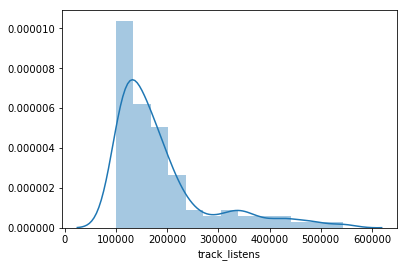

In [9]:
print(mod_tracks["track_listens"].describe())
print(mod_tracks[mod_tracks["popularity_index"] >= 800]["popularity_index"].describe())
sns.distplot(mod_tracks[mod_tracks["track_listens"] >= 100000]["track_listens"])

In [10]:
listens_label = mod_tracks["track_listens"][subset].map(lambda x: 1 if x > 800 else 0)
print(listens_label.unique())
listens_label = pd.DataFrame(listens_label, index=tracks.index)
print(listens_label.shape)

[1 0]
(8000, 1)


In [11]:
listens_label.track_listens.unique()

array([1, 0])

In [12]:
# Just be sure that everything is fine. Multiprocessing is tricky to debug.
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, listens_label, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape

(2, 1321967)

In [13]:
# Keras parameters.
# NB_WORKER = len(os.sched_getaffinity(0))  # number of usables CPUs
# NB_WORKER = 8 # len(os.sched_getaffinity(0))  # number of usables CPUs
params = {'pickle_safe': False, 'max_q_size': 10}

In [14]:
#train = train[:10]

In [ ]:

########################################
## define the model structure
########################################
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)


########################################
## add class weight
########################################
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
model.summary()
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

In [26]:
loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, listens_label, loader)
print('Dimensionality: {}'.format(loader.shape))

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(units=1000, input_shape=loader.shape))
model.add(Activation("relu"))
model.add(Dense(units=100))
model.add(Activation("relu"))
model.add(Dense(units=listens_label.shape[1]))
model.add(Activation("softmax"))

# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

with tf.device('/gpu:0'):
    model.fit_generator(SampleLoader(train, batch_size=1), train.size, epochs=5)
    loss = model.evaluate_generator(SampleLoader(val, batch_size=1), val.size)
    loss = model.evaluate_generator(SampleLoader(test, batch_size=1), test.size)
    Y = model.predict_generator(SampleLoader(test, batch_size=1), test.size);

loss

Dimensionality: (59953,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              59954000  
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               100100    
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 60,054,201
Trainable params: 60,054,201
Non-trainable params: 0
_______________________________________

[11.299165204912438, 0.29125000000000001]

In [ ]:
a = SampleLoader(train, batch_size=32)
print(a, type(a))

In [28]:
loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, listens_label, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, strides=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
# model.add(Dropout(0.4))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(listens_label.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit_generator(SampleLoader(train, batch_size=1), train.size, epochs=5)
    loss = model.evaluate_generator(SampleLoader(val, batch_size=1), val.size)
    loss = model.evaluate_generator(SampleLoader(test, batch_size=1), test.size)

loss

(None, 479625, 1)
(None, 936, 128)
(None, 929, 32)
(None, 225, 32)
(None, 56, 32)
(None, 1792)
(None, 100)
(None, 1)
Epoch 1/5
6400/6400 [==============================] - 958s 150ms/step - loss: 11.2917 - acc: 0.2917
Epoch 2/5
6400/6400 [==============================] - 958s 150ms/step - loss: 11.2892 - acc: 0.2919
Epoch 3/5
6400/6400 [==============================] - 958s 150ms/step - loss: 11.2917 - acc: 0.2917
Epoch 4/5
6400/6400 [==============================] - 955s 149ms/step - loss: 11.2917 - acc: 0.2917
Epoch 5/5
6400/6400 [==============================] - 954s 149ms/step - loss: 11.2867 - acc: 0.2920


[11.299165204912438, 0.29125000000000001]